In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt

# Prisoner's Dilemma
class PD:
  def __init__(self):
    # Actions: (C)ooperate, (D)efect
    self.actions = ['C','D']
    # Diagonal Payoff Matrix
    #    C  D
    # C 10  0
    # D 20  5
    self.rewards = {'C': {'C': 10, 'D': 0}, 'D': {'C': 20, 'D': 5}}

  # Returns rewards[actionA], rewards[actionB]
  def computeReward(self, actionA, actionB):
    return [self.rewards[actionA][actionB], self.rewards[actionB][actionA]]

  # Computes probabilities of cooperating/defecting after each of 4 possible outcomes
  def estimateStrategy(self, agent1, agent2, nrounds):
    coopP = {'CC':0, 'CD':0, 'DC':0, 'DD':0} # Tracks probabilities of cooperation after given outcomes
    defP = {'CC':0, 'CD':0, 'DC':0, 'DD':0}
    # p(C) after C,C last round, should be 1 in pure TfT and Pavlov
    # P(C) after C,D last round, should be 0 in pure TfT and Pavlov
    # P(C) after D,C last round, should be 1 in pure TfT and 0 in Pavlov
    # P(C) after D,D last round, should be 0 in pure TfT and 1 in Pavlov
    outcomes = {'CC':0, 'CD':0, 'DC':0, 'DD': 0} # Counts total occurences of such outcomes
    prevA = 'C'
    prevB = 'D'
    for i in range(nrounds):
      actionA = agent1.chooseAction()
      # Tit-for-Tat after round 1
      if i == 0:
        actionB = random.choice(self.actions)
      elif i > 0:
        actionB = prevA
        prevOutcome = prevA + prevB # Concatenate strings of each action
        outcomes[prevOutcome] += 1
        if actionA == 'C':
          coopP[prevOutcome] += 1
        else:
          defP[prevOutcome] += 1
      prevA = actionA
      prevB = actionB
      rewardA = self.computeReward(actionA, actionB)
      rewardB = self.computeReward(actionB, actionA)
      agent1.update(actionA, rewardA)
      agent2.update(actionB, rewardB)
    for outcome in outcomes.keys():
      if outcomes[outcome] > 0:
        # define cooperation probability (e.g. pCC) as the number of times agent cooperates after outcome occurs (e.g. CC)
        coopP[outcome] = coopP[outcome] / outcomes[outcome]
        defP[outcome] = defP[outcome] / outcomes[outcome]
    return coopP.values(), defP.values()

  # Plots the actions of each agent over time
  def plotStrategies(self, agent1, agent2, nrounds):
      actionsA = []
      actionsB = []
      tit_for_tat_compliance = []
      for i in range(nrounds):
          actionA = agent1.chooseAction()
          actionB = agent2.chooseAction()
          agent1.oppacts.append(actionB == 'D')
          agent2.oppacts.append(actionA == 'D')
          # Check if Agent 1 is following Tit-for-Tat
          # if i > 0 and actionA == actionsB[-1]:
          #     tit_for_tat_compliance.append(i)  # Mark round number where Tit-for-Tat was followed
          rewardA = self.computeReward(actionA, actionB)
          rewardB = self.computeReward(actionB, actionA)
          agent1.update(actionA, rewardA)
          agent2.update(actionB, rewardB)
          actionsA.append(actionA)
          actionsB.append(actionB)

      plt.figure(figsize=(12, 6))
      plt.plot(np.arange(nrounds), actionsA, 'o-', label="Agent 1")
      plt.plot(np.arange(nrounds), actionsB, 's-', label="Agent 2")

      plt.xlabel("Round")
      plt.ylabel("Action")
      plt.title("Prisoner's Dilemma Actions per Round")
      plt.legend()
      plt.grid(True)
      plt.show()


# Social Q-Learning
class SQlearning:
  def __init__(self, alpha=0.5, phi=0.5, beta = 0.5, gamma = 1.0, temperature = 15.0):
    ## Oxytocin -> increased social salience -> bigger alpha
    # Learning Rate Parameter
    self.alpha = alpha
    ## Serotonin -> prosocial behavior -> bigger phi and bigger beta
    # Fairness Parameter, higher value penalizes reward differences
    self.phi = phi
    # Temporal Discounting Parameter, higher value -> less discounting
    self.gamma = gamma
    # Altruism Parameter, higher value more altruistic (concerned about peer reward)
    self.beta = beta
    # Exploration Degree, higher value -> greater tendency to explore
    self.temperature = temperature
    self.oppacts = []
    # Initialize Q values at 0, 0
    self.Q = {'C': 0, 'D': 0}

  # Q-updating
  def update(self, action, rewards):
    self.temperature = max(self.temperature * 0.95, 0.1)
    # Compute net reward as sum of own reward + fraction of peer reward - fraction of reward difference
    net_reward = rewards[0] + self.beta * rewards[1] - self.phi * abs(rewards[0] - rewards[1])

    # Update Q value
    self.Q[action] += self.alpha * (net_reward + self.gamma * max(self.Q.values()) - self.Q[action])

  # Softmax choice function
  def chooseAction(self):
    # If agent selects actions randomly
    actions = list(self.Q.keys())
    exps = [np.exp((self.Q[a] - max(self.Q.values()))/ self.temperature) for a in actions] # Use temperature to modulate exploitation/exploration
    sum_exps = sum(exps)
    probs = [exp / sum_exps for exp in exps]
    return random.choices(actions, weights=probs, k=1)[0]


## Plotting Agent Actions Over Time
## Plotting Cooperation Probability in Response to Outcomes

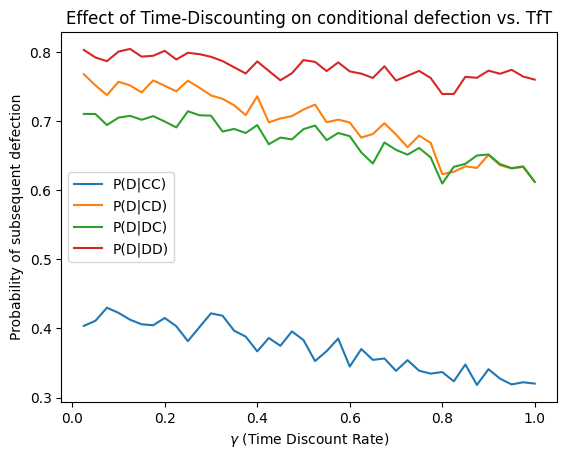

In [ ]:
PDtest = PD()

# # Play around with parameters phi (fairness), beta (altruism), gamma (time discount), temperature (exploration degree)
# agent1 = SQlearning(alpha = 0.3, phi=0.0, beta=0.0, gamma=1.0, temperature = 10.0) # Unfair-selfish agent
# agent2 = SQlearning(alpha = 0.3, phi=0.0, beta = 1.0, gamma=1.0, temperature = 10.0) # Pure altruist agent
# PDtest.plotStrategies(agent1, agent2, 50)
# # Outcome -> converges to Defect, Cooperate, sometimes Cooperate, Cooperate
# # Reasoning -- Agent1 exploits agent2's altruism and learns to always defect; agent2 is okay being exploited due to high altruism/low fairness
# # TODO: Try out other combinations and try to replicate empirical observations (e.g. Do high-serotonin expressing agents cooperate more?)
# from builtins import round  # Ensure the built-in round is used

nrounds = 30
epochs = 1000
PCC = []
PCD = []
PDC = []
PDD = []

for param in np.arange(0.025, 1.025, 0.025):
  p1 = 0
  p2 = 0
  p3 = 0
  p4 = 0
  for _ in range(epochs):
    agent1 = SQlearning(alpha = 0.3, phi=0.6, beta=0.2, gamma=param, temperature = 10.0)
    agent2 = SQlearning(alpha = 0.3, phi=0.5, beta=0.5, gamma=0.9, temperature = 10.0)
    [pcc, pcd, pdc, pdd] = PDtest.estimateStrategy(agent1, agent2, nrounds)[1] # Get defection probabilities
    p1 += pcc / epochs
    p2 += pcd / epochs
    p3 += pdc / epochs
    p4 += pdd / epochs
  PCC.append(p1)
  PCD.append(p2)
  PDC.append(p3)
  PDD.append(p4)
print('\n')
plt.plot(np.arange(0.025, 1.025, 0.025), PCC, label="P(D|CC)")
plt.plot(np.arange(0.025, 1.025, 0.025), PCD, label="P(D|CD)")
plt.plot(np.arange(0.025, 1.025, 0.025), PDC, label="P(D|DC)")
plt.plot(np.arange(0.025, 1.025, 0.025), PDD, label="P(D|DD)")
plt.xlabel(r"$\gamma$ (Time Discount Rate)")
plt.ylabel("Probability of subsequent defection")
plt.title("Effect of Time-Discounting on conditional defection vs. TfT")
plt.legend()
plt.show()

## Heatmaps for Varying Fairness and Altruism

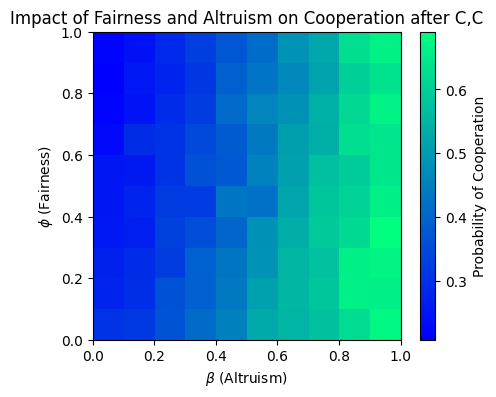

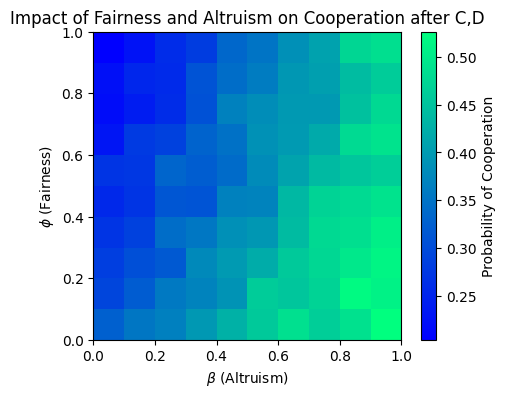

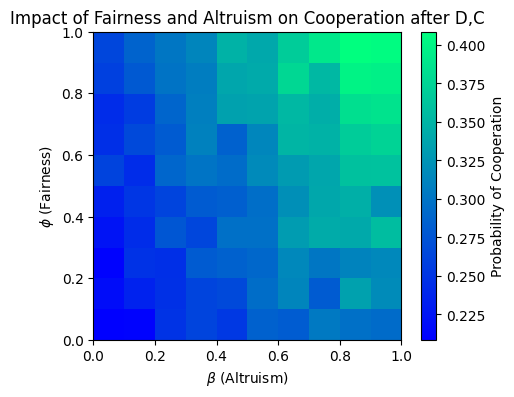

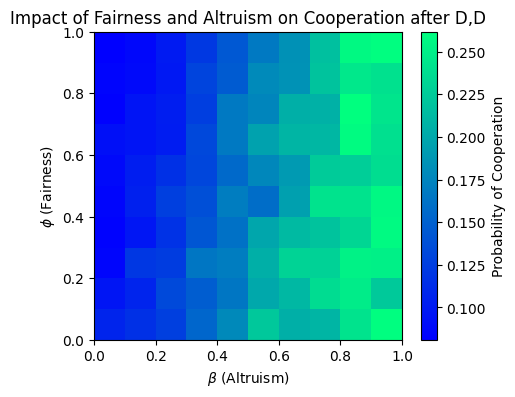

In [ ]:

phi_values = np.linspace(0, 1, 10)
beta_values = np.linspace(0, 1, 10)
resultCC = np.zeros((len(phi_values), len(beta_values)))
resultCD = np.zeros((len(phi_values), len(beta_values)))
resultDC = np.zeros((len(phi_values), len(beta_values)))
resultDD = np.zeros((len(phi_values), len(beta_values)))

# Run the simulations
for i, phi in enumerate(phi_values):
    for j, beta in enumerate(beta_values):
        avg_outcome = [0, 0, 0, 0]
        for _ in range(epochs):
            agent1 = SQlearning(alpha=0.3, phi=phi, beta=beta, gamma=0.9, temperature=10.0)
            agent2 = SQlearning(alpha=0.3, phi=0.1, beta=0.3, gamma=1.0, temperature=10.0)
            probs = PDtest.estimateStrategy(agent1, agent2, nrounds)[0] # Get cooperation probabilities
            for k, prob in enumerate(probs):
              avg_outcome[k] += prob / epochs  # Focusing on cooperation outcomes
        resultCC[i, j] = avg_outcome[0]
        resultCD[i, j] = avg_outcome[1]
        resultDC[i, j] = avg_outcome[2]
        resultDD[i, j] = avg_outcome[3]


# Plotting the heatmap
plt.figure(figsize=(5, 4))
im = plt.imshow(resultCC, cmap='winter', interpolation='nearest', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(im, label='Probability of Cooperation')
plt.xlabel(r'$\beta$ (Altruism)')
plt.ylabel(r'$\phi$ (Fairness)')
plt.title('Impact of Fairness and Altruism on Cooperation after C,C')
plt.show()

# # Plotting the heatmap
plt.figure(figsize=(5, 4))
im = plt.imshow(resultCD, cmap='winter', interpolation='nearest', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(im, label='Probability of Cooperation')
plt.xlabel(r'$\beta$ (Altruism)')
plt.ylabel(r'$\phi$ (Fairness)')
plt.title('Impact of Fairness and Altruism on Cooperation after C,D')
plt.show()

# # Plotting the heatmap
plt.figure(figsize=(5, 4))
im = plt.imshow(resultDC, cmap='winter', interpolation='nearest', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(im, label='Probability of Cooperation')
plt.xlabel(r'$\beta$ (Altruism)')
plt.ylabel(r'$\phi$ (Fairness)')
plt.title('Impact of Fairness and Altruism on Cooperation after D,C')
plt.show()


# # Plotting the heatmap
plt.figure(figsize=(5, 4))
im = plt.imshow(resultDD, cmap='winter', interpolation='nearest', origin='lower', extent=[0, 1, 0, 1])
plt.colorbar(im, label='Probability of Cooperation')
plt.xlabel(r'$\beta$ (Altruism)')
plt.ylabel(r'$\phi$ (Fairness)')
plt.title('Impact of Fairness and Altruism on Cooperation after D,D')
plt.show()